In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
% matplotlib inline
pd.set_option('display.max_columns', None, 'display.max_rows', 20)


drive.mount('/content/gdrive')
PATH = 'gdrive/Shared drives/109  統計&DL 期末專案/Dataset/Concat_Behavior_Data'
os.chdir(PATH)

# mem_in6 = pd.read_csv('member_data_for_6.csv')


# mem_in6 = pd.read_csv('member_feature_behav_in6.csv', header=0).fillna(0)
# eland_in6 = pd.read_csv('eland_in6.csv').fillna(0)

Mounted at /content/gdrive


# Model class

最後呈現，建df，每個model的相對數據
可加：knn, svm

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [33]:
class models():
    def __init__(self,df):
        self.df = df # original df
        self.result_dict = {}
        self.bestParam_df = pd.DataFrame(columns=['model_name','param','rmse'])
        self.X_droplist = []
        self.ifNeedValid = ''
        self.best_model = None
        self.classification_report = None
        
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        
    def data_processing(self,ResamplingType,X_droplist,ifNeedValid):
        # if resampling
        self.X_droplist = X_droplist
        self.resample_type = ResamplingType
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df.drop(self.X_droplist+['purchase'],axis=1)\
                                                            ,self.df['purchase'], test_size=0.33, random_state=80)
        
        self.ifNeedValid = ifNeedValid
        data = pd.concat([self.X_train,self.y_train], axis=1)

        
        label1 = data[data['purchase']==1]
        label0 = data[data['purchase']==0]
        
        if (self.resample_type == "under"):
            label0 = label0.sample(len(label1))
        elif (self.resample_type == "over"):
            label1 = label1.sample(len(label0), replace=True, random_state=100)
            # label0 = label0.sample(15000)
            
        in_balance_df = pd.concat([label1,label0], axis=0)
        self.X_train = in_balance_df.drop(['purchase'],axis=1)
        self.y_train = in_balance_df['purchase']
        
        # print('self.X_train.shape:',self.X_train.shape,'self.y_train.shape:',self.y_train.shape)
        
        if self.ifNeedValid=='valid':
            self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X_train,self.y_train,test_size = 0.1, random_state=10)
            # print('self.X_valid.shape:',self.X_valid.shape,'self.y_valid.shape:',self.y_valid.shape) 
            
        # print('self.X_test.shape:',self.X_test.shape,'self.y_test.shape:',self.y_test.shape)
        # print()
        # print('used columns:',self.X_train.columns)
        

        
    def train_randomforest(self):
        
        result_list = []
        for estimator_i in [10]: # ,50,100,500
            for features_i in ['auto']: # ,'sqrt','log2'
                for depth_i in [20]:# 1,2,8,10,,40,50
                    for criterion_i in ['entropy']:# 'gini',
                        rfc=RandomForestClassifier(random_state=0,max_depth=depth_i,max_features=features_i,\
                                                   n_estimators=estimator_i,criterion=criterion_i)
                        rfc.fit(self.X_train,self.y_train)
                        y_pred = rfc.predict(self.X_test)
                        rmse = mean_squared_error(y_pred,self.y_test)
                        report = classification_report(self.y_test, y_pred, labels=[1,0],output_dict=True)
                        self.classification_report = report
                        result_list.append({'precision':report['1']['precision'],'recall':report['1']['recall'],\
                                            'f1-score':report['1']['f1-score'],'accuracy':report['accuracy'],'rmse':rmse,\
                                            'max_depth':depth_i,'max_features':features_i,\
                                            'n_estimators':estimator_i,'criterion':criterion_i})
                        # self.feature_importance(rfc)
        
        self.result_dict['rfc'] = result_list
        
        

        
    def train_lossoRegre(self):
        
        sc = StandardScaler()
        sc.fit(self.X_train)
        X_train = sc.transform(self.X_train)
        sc = StandardScaler()
        sc.fit(self.X_test)
        X_test = sc.transform(self.X_test)

        result_list = []
        for penalty_i in ['l2','none']:
            LoRegre = LogisticRegression(random_state=0,max_iter=10000,penalty=penalty_i,multi_class='ovr').fit(X_train, self.y_train)
            y_pred = LoRegre.predict(X_test)
            rmse = mean_squared_error(y_pred,self.y_test)
            report = classification_report(self.y_test, y_pred, labels=[1,0],output_dict=True)
            result_list.append({'precision':report['1']['precision'],'recall':report['1']['recall'],\
                                'f1-score':report['1']['f1-score'],'accuracy':report['accuracy'],'rmse':rmse,\
                                'penalty':penalty_i})
        self.result_dict['lossoRegre'] = result_list
        
    def train_gradientBoosting(self):
        
        result_list = []

        for loss_i in ['deviance','exponential']:
            GB = GradientBoostingClassifier(random_state=0,loss=loss_i)
            GB.fit(self.X_train,self.y_train)
            y_pred = GB.predict(self.X_test)
            rmse = mean_squared_error(y_pred,self.y_test)
            report = classification_report(self.y_test, y_pred, labels=[1,0],output_dict=True)
            result_list.append({'precision':report['1']['precision'],'recall':report['1']['recall'],\
                                'f1-score':report['1']['f1-score'],'accuracy':report['accuracy'],'rmse':rmse,\
                                'loss':loss_i})
        self.result_dict['GB'] = result_list
            
    
    def train_knn(self):

      result_list = []
      for Nneighbor_i in [3,5,10,15]:
        for leafSize_i in [10,30,50]:
          knn = KNeighborsClassifier(n_neighbors=Nneighbor_i,leaf_size=leafSize_i)
          knn.fit(self.X_train,self.y_train)
          y_pred = knn.predict(self.X_test)
          rmse = mean_squared_error(self.y_test,y_pred)
          report = classification_report(self.y_test,y_pred,labels=[1,0],output_dict=True)
          result_list.append({'precision':report['1']['precision'],'recall':report['1']['recall'],\
                              'f1-score':report['1']['f1-score'],'accuracy':report['accuracy'],'rmse':rmse,\
                              'n_neighbors':Nneighbor_i,'leaf_size':leafSize_i})
          

      self.result_dict['knn'] = result_list

        
    def draw_rmse(self,model_name,param_type):

        param_list = self.result_dict[model_name]

        for param_i in param_type:
          param_df = pd.DataFrame.from_dict(param_list).groupby([param_type]).mean()
          # print('x:',param_df.index)
          # print('y:',param_df['rmse'])
          plt.plot(param_df.index,param_df['rmse'])

        plt.title(model_name+' rmse')
        plt.show()

    def draw_metrics(self,model_name):
      metrics_df = result_list[model_name]
        
        
    def best_param(self,metrics_type):
        self.bestParam_df = pd.DataFrame(columns=['model_name','precision','recall','f1-score','accuracy','rmse','param'])
        for key in self.result_dict.keys():
            model_df = pd.DataFrame.from_dict(self.result_dict[key])
            param_i = pd.DataFrame.from_dict(model_df)[metrics_type].idxmax(axis=0)
            self.bestParam_df = self.bestParam_df.append({'model_name':key,'precision':model_df.iloc[param_i,0],\
                                                          'recall':model_df.iloc[param_i,1],'f1-score':model_df.iloc[param_i,2],'accuracy':model_df.iloc[param_i,3],\
                                                          'rmse':model_df.iloc[param_i,4],\
                                                          'param':model_df.iloc[param_i,5:],}\
                                                         ,ignore_index=True)
        
     
        
    def multi_model_rmse(self,metrics_type):
        plt.clf()
        # plt.plot(self.bestParam_df.loc[:,'model_name'],self.bestParam_df.loc[:,metrics_type])
        plt.bar(self.bestParam_df.loc[:,'model_name'],self.bestParam_df.loc[:,metrics_type])
        plt.show()

    def feature_importance(self,model):

      feature_importance = list(zip(self.X_train.columns,model.feature_importances_))
      feature_importance = sorted(feature_importance,key=lambda l:l[1],)
      features = [i[0] for i in feature_importance]
      importance = [i[1] for i in feature_importance]

      fig, ax = plt.subplots(figsize=(10,8))
      ax.barh(features,importance)
      ax.set_title('feature importance',pad=10)
      plt.show()
          



## Data preprocessing

In [ ]:
# preproccessing 
# features in learning 
member_features = ['Age','RegisterSourceTypeDef','Gender','IsAppInstalled','IsEnableEmail','IsEnablePushNotification','IsEnableShortMessage','MemberCardLevel'] #
member_charactaristic = ['CAI','recency', 'frequency', 'monetary','2week_purchase','1week_purchase','1month_purchase', \
                   'con_viewcategory','con_viewproduct', 'con_traffic', 'con_viewmainpage','con_viewactivity', 'con_add', 'con_checkout', 'con_search','con_purchase']  # 
member_behavior = ['mean_of_search','attention_of_product','cart_porpotion','behav_per_day']
# ,
def df_preprocessing(df,predict_i):
  df = pd.read_csv(df)
  df = df.dropna(subset=['bh'])
  df = df[member_features+member_charactaristic+member_behavior]
  dummies = ['Gender','IsAppInstalled','IsEnableEmail','IsEnablePushNotification','IsEnableShortMessage','RegisterSourceTypeDef']
  for dummy in dummies:
    df_dummy = pd.get_dummies(df[dummy],drop_first=True,prefix=dummy)  
    df = pd.concat([df,df_dummy],axis=1).drop(dummy,axis=1)
  df = df.fillna(0)

  for del_purchase_i in purchase_list:
    if del_purchase_i != predict_i:
      df = df.drop([del_purchase_i],axis=1)
  df = df.rename(columns={predict_i:'purchase'})
  return df 



## Training

In [34]:
dataset_dict = {}
modelss = {}

filename_list = os.listdir()
purchase_list = ['1week_purchase','2week_purchase','1month_purchase']
print(filename_list)
for mem_in_ in filename_list:
  if 'mem_in' in mem_in_:
    pred_dict = {}
    for predict_i in purchase_list:
      df = df_preprocessing(mem_in_,predict_i)
      models_ = models(df)
      for sampling_i in ['']:
        models_.data_processing(sampling_i,[],'')
      

        ## train data
        models_.train_randomforest()
        # models_.train_lossoRegre()
        # models_.train_gradientBoosting()
        # models_.train_knn()

        ## tuning parameter
        # models_.draw_rmse('lossoRegre','penalty')
        # models_.draw_rmse('knn','n_neighbors')
        # models_.draw_rmse('rfc','n_estimators')

        ## models comparison
        models_.best_param('f1-score')
        # print(models_.bestParam_df)
        # models_.multi_model_rmse('f1-score')

        modelss[mem_in_[11:-3]+' '+predict_i+' '+sampling_i] = models_
        
      if mem_in_[-12:-4] in dataset_dict.keys():
        if predict_i in dataset_dict[mem_in_[-12:-4]].keys():
          dataset_dict[mem_in_[-12:-4]][predict_i] += float(models_.bestParam_df['f1-score'])
        else:
          dataset_dict[mem_in_[-12:-4]][predict_i] = float(models_.bestParam_df['f1-score'])
      else:
        dataset_dict[mem_in_[-12:-4]] = {predict_i:float(models_.bestParam_df['f1-score'])}
  
      
      

      
    

['OrderData.csv', 'OrderSlaveData.csv', 'MemberData.csv', 'activityPageView.csv', 'mainPageView.csv', 'addToCart.csv', 'trafficSource.csv', 'categoryPageView.csv', 'userRegisteration.csv', 'purchase.csv', 'checkout.csv', 'productPageView.csv', 'search.csv', '2019_total_behavior.csv', 'June_total_behavior.csv', '91APP_profile.xlsx', 'eland_in6.csv', 'member_feature.csv', 'member_feature_behav_in6.csv', 'total_behavior_all.csv', 'member_data_for_6.csv', 'mem_in_2019_2_behav_7.csv', 'mem_in_2019_3_behav_7.csv', 'mem_in_2019_4_behav_7.csv', 'mem_in_2019_5_behav_7.csv', 'mem_in_2019_6_behav_7.csv', 'mem_in_2019_7_behav_7.csv', 'mem_in_2019_8_behav_7.csv', 'mem_in_2019_9_behav_7.csv', 'mem_in_2019_10_behav_7.csv', 'mem_in_2019_11_behav_7.csv', 'mem_in_2019_12_behav_7.csv', 'mem_in_2019_2_behav_14.csv', 'mem_in_2019_3_behav_14.csv', 'mem_in_2019_4_behav_14.csv', 'mem_in_2019_5_behav_14.csv', 'mem_in_2019_6_behav_14.csv', 'mem_in_2019_7_behav_14.csv', 'mem_in_2019_8_behav_14.csv', 'mem_in_2019

In [ ]:
# ppt 資料集調整參數 data

columns = ['x period','y period'] + ['dataset'+str(i) for i in range(1,12)]
index2_df = pd.DataFrame(columns=columns)

for x in ['behav_7','behav_14','behav_21','behav_30']:
  for y in ['1week','2week','1month']:
    per_index_list = []
    for data_i in range(2,13):
      dataname = "_"+str(data_i)+"_"+x+". "+y+"_purchase "
      per_index_list.append(float(modelss[dataname].bestParam_df['f1-score']))
    temp_dict = {'x period':x,'y period':y}
    for i in range(0,11):
      temp_dict[columns[i+2]] = per_index_list[i] 
    index2_df = index2_df.append(temp_dict,ignore_index=True)
index2_df




,x period,y period,dataset1,dataset2,dataset3,dataset4,dataset5,dataset6,dataset7,dataset8,dataset9,dataset10,dataset11
0,behav_7,1week,0.483221,0.552632,0.561111,0.472393,0.343195,0.412500,0.500000,0.538153,0.540925,0.543147,0.630000
1,behav_7,2week,0.405694,0.548544,0.523894,0.559350,0.342105,0.433898,0.647191,0.563981,0.507246,0.646154,0.616046
2,behav_7,1month,0.535922,0.533762,0.514286,0.430556,0.426426,0.626230,0.618182,0.581921,0.632558,0.636150,0.665302
3,behav_14,1week,0.472050,0.520000,0.509284,0.370588,0.397727,0.364780,0.513514,0.546075,0.568047,0.531250,0.555831
4,behav_14,2week,0.390093,0.557957,0.522835,0.488688,0.373626,0.441989,0.636559,0.544402,0.575758,0.629393,0.565161
5,behav_14,1month,0.497638,0.512758,0.451351,0.390438,0.404348,0.535565,0.545794,0.544843,0.593407,0.598383,0.606178
6,behav_21,1week,0.453039,0.503704,0.493438,0.379404,0.447368,0.357143,0.454545,0.531250,0.589812,0.479508,0.569507
7,behav_21,2week,0.403270,0.525328,0.496753,0.463768,0.407216,0.422886,0.639098,0.550098,0.573503,0.622289,0.557870
8,behav_21,1month,0.478873,0.549451,0.413333,0.419463,0.393939,0.530026,0.489985,0.547798,0.592718,0.571181,0.603503
9,behav_30,1week,0.400000,0.525180,0.490654,0.426606,0.408163,0.367568,0.467532,0.528662,0.548718,0.494624,0.537118


## plot data

### plot 4 metric (for one model)

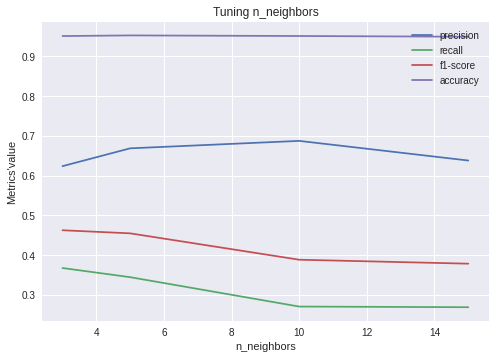

In [ ]:
result_data = pd.DataFrame.from_dict(modelss['_7_behav_30.1month_purchase'].result_dict['knn'])

def plot_4metric(data,param):
  metric_mean_list = []
  group_mean = result_data.groupby(param).mean()

  plt.clf()
  for metric_i in ['precision','recall','f1-score','accuracy']:
    plt.plot(group_mean.index, group_mean[metric_i],label=metric_i)
    # plt.plot(result_data.loc[:,param],result_data.loc[:,metric_i])
  plt.legend()
  plt.xlabel(param)
  plt.ylabel('Metrics\'value')
  plt.title('Tuning '+param)
  plt.show()

  

plot_4metric(result_data,'n_neighbors')

# 'max_depth':depth_i,'max_features':features_i,\
#                                             'n_estimators':estimator_i,'criterion':criterion_i})

### plot two dataset parameter tuning result

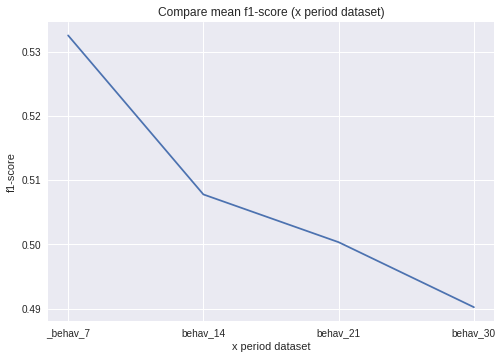

In [ ]:

def single_param_dataset(paramtype):
  plt.clf()
  
  mean_list = []
  label_list = []
  x_label = ''
  if paramtype == 'behav':
    mean_list = [dataset_df[x].mean()/11 for x in dataset_df.columns]
    label_list = dataset_df.columns
    x_label = 'x period dataset'
    
  elif paramtype == 'pred':
    mean_list = [dataset_df.iloc[x,:].mean()/11 for x in range(len(dataset_df))]
    label_list = dataset_df.index
    x_label = 'Predict y period'
    
  
  plt.plot(label_list,mean_list)
  plt.ylabel('f1-score')
  plt.xlabel(x_label)
  plt.title('Compare mean f1-score (' + x_label + ')')
  plt.show()

  
dataset_df = pd.DataFrame.from_dict(dataset_dict)
single_param_dataset('behav')

### Multi_model_metrics

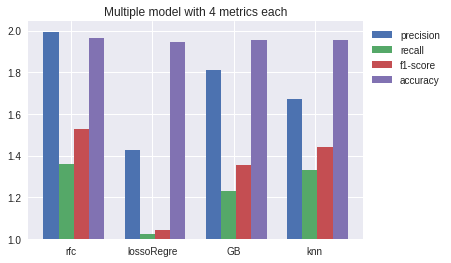

In [ ]:
def multi_model_rmse(df):
  metrics_num = 4
  w = 0.75
  metrics_w = w/metrics_num

  fig,ax = plt.subplots()
  x = np.arange(len(df))

  for i in range(metrics_num):
    y = df.iloc[:,i+1]
    b = ax.bar(x+i*metrics_w,y,metrics_w,bottom=1,label=df.columns[i+1])

  ax.set_xticks(x+0.25)
  ax.set_xticklabels(df.iloc[:,0].tolist())
  ax.legend(bbox_to_anchor=(1,1))
  ax.set_title('Multiple model with 4 metrics each')
  plt.show()
    

multi_model_rmse(modelss['_8_behav_30.1month_purchase'].bestParam_df)

### heatmap

{'_behav_7': {'1week_purchase': 5.577277156345055, '2week_purchase': 5.794102728674265, '1month_purchase': 6.201294633581367}, 'behav_14': {'1week_purchase': 5.349146092929405, '2week_purchase': 5.726459931143029, '1month_purchase': 5.680702665744494}, 'behav_21': {'1week_purchase': 5.258718480344099, '2week_purchase': 5.662079289594484, '1month_purchase': 5.590270147175373}, 'behav_30': {'1week_purchase': 5.194824795660121, '2week_purchase': 5.536597286061276, '1month_purchase': 5.445951454606411}}


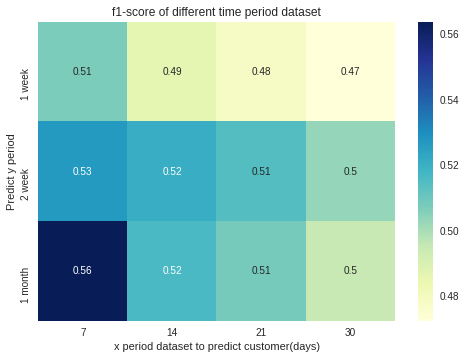

In [ ]:
import seaborn as sns

simu = {6:{1:444,2:555,3:666},
        7:{1:364,2:123,3:656},
        8:{1:343,2:675,3:346},
        9:{1:212,2:897,3:456}}
x = ['7','14','21','30']
y = ['1 week','2 week','1 month']
print(dataset_dict)
simu = pd.DataFrame.from_dict(dataset_dict)
simu = simu/11

sns.heatmap(simu,xticklabels=x,yticklabels=y,cmap="YlGnBu",annot=True)
plt.title('f1-score of different time period dataset')
plt.ylabel('Predict y period')
plt.xlabel('x period dataset to predict customer(days)')

plt.show()

### 模型表現

['_2_behav_7.1month_purchase', '_3_behav_7.1month_purchase', '_4_behav_7.1month_purchase', '_5_behav_7.1month_purchase', '_6_behav_7.1month_purchase', '_7_behav_7.1month_purchase', '_8_behav_7.1month_purchase', '_9_behav_7.1month_purchase', '_10_behav_7.1month_purchase', '_11_behav_7.1month_purchase', '_12_behav_7.1month_purchase']


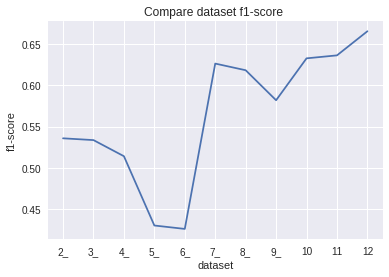

In [ ]:
f1_list = []
dataname_list = list(modelss.keys())
print(dataname_list)
for dataname in dataname_list:
  f1_list.append(float(modelss[dataname].result_dict['rfc'][0]['f1-score']))

dataname_list = [i[1:3] for i in list(modelss.keys())]
plt.clf()
plt.plot(dataname_list,f1_list)
plt.ylabel('f1-score')
plt.xlabel('dataset')
plt.title('Compare dataset f1-score ')
plt.show()


In [30]:
model_list = list(modelss.keys())
ave_df = pd.DataFrame.from_dict(modelss[model_list[0]].classification_report).transpose()
for modelss_i in model_list[1:]:
  ave_df = ave_df.add(pd.DataFrame.from_dict(modelss[modelss_i].classification_report).transpose())
ave_df = ave_df/11

ave_df

,precision,recall,f1-score,support
1,10.766078,4.308449,6.092493,4732.454545
0,11.592183,11.966320,11.775806,88130.363636
accuracy,11.572438,11.572438,11.572438,11.572438
macro avg,11.179131,8.137385,8.934150,92862.818182
weighted avg,11.546710,11.572438,11.488184,92862.818182
